<a name="software-requirements"></a>
## Software Requirements

In [1]:
# Import modules
# Data visualization
import matplotlib.pyplot as plt
import cartopy

# Data manipulation
import pandas as pd
import numpy as np
import xarray as xr

# todo: mount GPU on colab.

<a name="data"></a>
# Data

In [2]:
repo_root = '../'
data_root = repo_root + 'data/'
path_climatebench_data = data_root + 'raw/climatebench/' # climatebench data

In [3]:
ls '../data/raw/climatebench/'

inputs_1pctCO2.nc*         inputs_ssp370.nc*         outputs_ssp126.nc*
inputs_abrupt-4xCO2.nc*    inputs_ssp585.nc*         outputs_ssp245.nc*
inputs_hist-GHG.nc*        outputs_1pctCO2.nc*       outputs_ssp370-lowNTCF.nc*
inputs_hist-aer.nc*        outputs_abrupt-4xCO2.nc*  outputs_ssp370.nc*
inputs_historical.nc*      outputs_hist-GHG.nc*      outputs_ssp585.nc*
inputs_ssp126.nc*          outputs_hist-aer.nc*      test.tar.gz*
inputs_ssp245.nc*          outputs_historical.nc*    train_val.tar.gz*
inputs_ssp370-lowNTCF.nc*  outputs_piControl.nc*


## Data Preprocessing <a name="data-processing"></a>


In [4]:
#@title code: load ClimateBench training data
from emcli.dataset.climatebench import load_climatebench_data

scenarios_train = ['ssp126','ssp370','ssp585','hist-GHG','hist-aer'] # could leave out hist-aer for training, but didn't really impact nrmse
data_path = path_climatebench_data + '/'

X_train, Y_train = load_climatebench_data(
  simus=scenarios_train, len_historical=0, 
  data_path=data_path)

Frozen({'time': 86, 'longitude': 144, 'latitude': 96}) ssp126
Frozen({'time': 86, 'longitude': 144, 'latitude': 96}) ssp370
Frozen({'time': 86, 'longitude': 144, 'latitude': 96}) ssp585
Frozen({'time': 165, 'longitude': 144, 'latitude': 96}) hist-GHG
Frozen({'time': 165, 'longitude': 144, 'latitude': 96}) hist-aer


In [5]:
#@title code: Normalize training data
# note: climatebench does not normalize outputs, Y_train.
from emcli.dataset.climatebench import compute_mean_std_X_train
from emcli.dataset.climatebench import normalize_data_arr

# Compute mean and standard deviations of each input variable
meanstd_inputs = {}
for var in ['CO2', 'CH4', 'SO2', 'BC']:
    meanstd_inputs[var] = compute_mean_std_X_train(data_arr = X_train, var=var)
# Normalize the input data array.
# X_train_norm = normalize_data_arr(data_arr=X_train, meanstd=meanstd_inputs, keys=['CO2', 'CH4', 'SO2', 'BC'])


In [6]:
#@title code: Load test data

scenarios_test = ['ssp245']
len_historical = 165

X_test, Y_test = load_climatebench_data(
  simus=scenarios_test, 
  len_historical=len_historical, 
  data_path=data_path,
  avg_over_ensemble=True)

# opt: Drop non-relevant variables
# X_test = [X.drop(['SO2','CH4','BC']) for X in X_test]
# Y_test = [Y.drop(['diurnal_temperature_range','pr','pr90']) for Y in Y_test]

# Normalize test data
# X_test_norm = normalize_data_arr(data_arr=X_test, meanstd=meanstd_inputs)#, keys=['CO2', 'CH4', 'SO2', 'BC'])
# todo: verify Y_test normalization in https://github.com/duncanwp/ClimateBench/blob/main/baseline_models/CNN-LTSM_model.ipynb

Frozen({'time': 251, 'longitude': 144, 'latitude': 96}) ssp245


In [7]:
print('Input', X_train[0].data_vars)
print('Output', Y_train[0].data_vars)
print('Training set, number of scenarios: \t\t', len(X_train))
print('Total number of training samples/years: \t', sum([X_scenario['CO2'].shape[0] for X_scenario in X_train]))
print('Training set, shapes of CO2 inputs: \t\t', X_train[0]['CO2'].shape, X_train[-1]['CO2'].shape)
print('Training set, shapes of BC (not used): \t\t', X_train[0]['BC'].shape, X_train[-1]['BC'].shape)
print('Training set, shapes of tas outputs: \t\t', Y_train[0]['tas'].shape, Y_train[-1]['tas'].shape)
print('Test set, number of scenarios:\t\t\t', len(X_test))
print('Test set, shape of CO2 input and tas output:\t', X_test[0]['CO2'].shape, Y_test[0]['tas'].shape)
print('Mean and standard deviations:')
[print('\t' + key + ' train mean, std: \t', meanstd_inputs[key]) for key in meanstd_inputs];

Input Data variables:
    CO2      (time) float64 1.536e+03 1.572e+03 ... 2.798e+03 2.793e+03
    SO2      (time, latitude, longitude) float64 0.0 0.0 0.0 ... 0.0 3.525e-14
    CH4      (time) float64 0.3737 0.3657 0.3576 0.3496 ... 0.115 0.1143 0.1136
    BC       (time, latitude, longitude) float64 0.0 0.0 0.0 ... 0.0 4.3e-15
Output Data variables:
    diurnal_temperature_range  (time, latitude, longitude) float32 -0.09124 ....
    tas                        (time, latitude, longitude) float32 0.7464 ......
    pr                         (time, latitude, longitude) float64 0.03614 .....
    pr90                       (time, latitude, longitude) float64 0.07835 .....
Training set, number of scenarios: 		 5
Total number of training samples/years: 	 588
Training set, shapes of CO2 inputs: 		 (86,) (165,)
Training set, shapes of BC (not used): 		 (86, 96, 144) (165, 96, 144)
Training set, shapes of tas outputs: 		 (86, 96, 144) (165, 96, 144)
Test set, number of scenarios:			 1
Test set,

## Data Visualization:


In [48]:
data_var_labels = {
    'tas': {
        'ylabel': 'Annual Global Surface \n Temperate Anomaly in °C',
        'title': 'Surface Temperature, "tas"',
        'unit': '°C',
    },
    'pr': {
        'ylabel': 'Annual Mean Precipitation Anomaly in mm/day',
        'title': 'Precipitation, "pr"',
        'unit': 'mm/day',
    },
    'diurnal_temperature_range': {
        'ylabel': 'Annual Diurnal Temperature Range Anomaly in °C',
        'title': 'Diurnal Temperature Range, "dtr"',
        'unit': '°C',
    },
    'pr90': {
        'ylabel': 'Annual Mean Extreme Precipitation Anomaly in mm/day',
        'title': 'Extreme Precipitation, "pr90"',
        'unit': 'mm/day',
    }
}

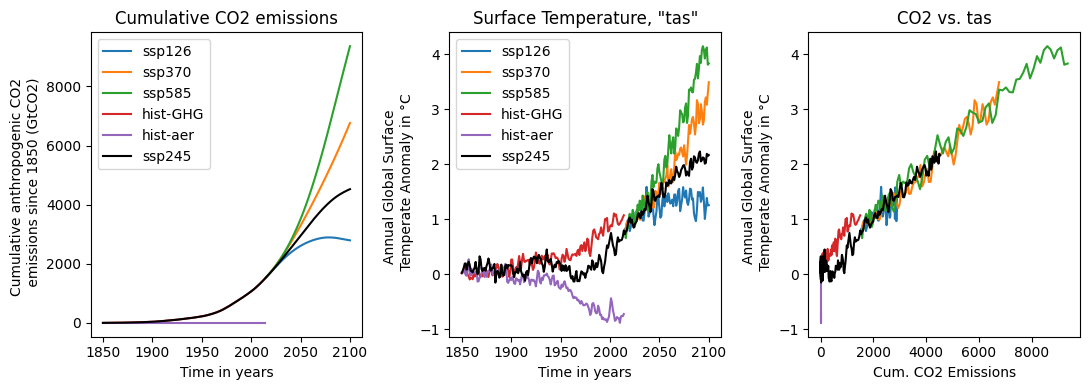

In [23]:
%reload_ext autoreload
%aimport emcli

import emcli.utils.plotting as plotting
data_var = 'tas'
plotting.plot_co2_data_var_global_over_time(X_train=X_train,
          X_test=X_test, 
          Y_train=Y_train, 
          Y_test=Y_test,
          scenarios_train=scenarios_train,
          scenarios_test=scenarios_test,
          data_var=data_var,
          data_var_labels=data_var_labels);

<a name="methodology"></a>
# Methodology

#### Linear time-instant: global GHG -> global tas

In [49]:
#@title: fit linear model for global GHGs -> global tas

import emcli.models.pattern_scaling.model as ps
import emcli.dataset.interim_to_processed as i2p

# Convert training data from interim to processed
data_var = 'tas' # Other variables can be plotted, but our Linear Pattern Scaling should always use global 'tas' as intermediate. 'tas', 'pr', 'pr90', 'diurnal_temperature_range'
dir_global_global = data_root + 'interim/global_global/'
input_train, target_train = i2p.interim_to_global_global(
                             X_global_local=X_train,
                             Y_global_local=Y_train,
                             input_keys=['CO2'],
                             target_keys=[data_var],
                             save_dir=dir_global_global+'train/')

print(target_train.shape)
# Fit Linear regression model from global ghg at t -> global data_var as t
model_lr = ps.fit_linear_regression_global_global(data_dir=dir_global_global+'train/', plot=False)

# Save model
dir_pattern_scaling = repo_root + 'runs/pattern_scaling/default/models/'
model_name = f'global_co2_to_global_{data_var}.pkl'
ps.save(model_lr, dir=dir_pattern_scaling, filename=model_name)

# Convert test data from interim to processed
input_test, target_test = i2p.interim_to_global_global(X_global_local=X_test, # [X_train[2]],# 
                             Y_global_local=Y_test, # [Y_train[2]],#
                             input_keys=['CO2'],
                             target_keys=[data_var],
                             save_dir=dir_global_global+'test/')

# Load model
# model_lr = ps.load(dir=dir_pattern_scaling, filename=model_name)

# Apply linear regression model on test data
preds_lr = ps.predict_linear_regression_global_global(model_lr, 
            data_dir=dir_global_global+'test/',
            plot=False)

Saving processed data at:  ../data/interim/global_global/train/
(588, 1, 1, 1)
Saving processed data at:  ../data/interim/global_global/test/


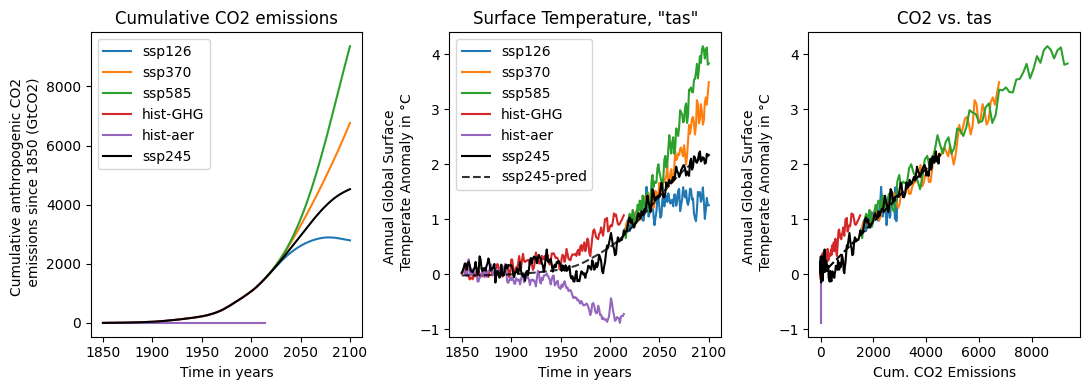

In [34]:
# Plot linear regression predictions

import emcli.utils.plotting as plotting
plotting.plot_co2_data_var_global_over_time(X_train=X_train,
          X_test=X_test, 
          Y_train=Y_train, 
          Y_test=Y_test,
          scenarios_train=scenarios_train,
          scenarios_test=scenarios_test,
          preds=preds_lr,
          data_var=data_var,
          data_var_labels=data_var_labels);

#### Linear pattern scaling: global tas -> local tas

##### To calculate metrics for each data variable, change "data_var" here.

In [57]:
#@title: fit linear pattern scaling model for global tas -> local tas

import emcli
import importlib
importlib.reload(emcli)
#from emcli.models.pattern_scaling.model import PatternScaling
#from emcli.models.pattern_scaling.model import save
import emcli.models.pattern_scaling.model as ps

################
# Change data_var here to calculate metrics for each variable
# 
data_var = 'tas' # 'tas', 'pr', 'pr90', 'diurnal_temperature_range'
# 
###############
# Retrieve global temperatures for training
var_global = target_train.flatten() # (n_time,)
# Retrieve annual local temperature field for training
var_local = np.concatenate([dataset[data_var].data for dataset in Y_train],axis=0) # (n_time, n_lat, n_lon)

# Initialize and fit pattern scaling model
pattern_scaling = ps.PatternScaling(deg=1)
pattern_scaling.train(var_global, var_local)

# Save model
dir_pattern_scaling = repo_root + 'runs/pattern_scaling/default/models/'
model_name = f'global_tas_to_local_{data_var}.pkl'
ps.save(pattern_scaling, dir=dir_pattern_scaling,filename=model_name)

# Retrieve test data. Use global tas predictions from previous model as input
var_global_test = preds_lr.flatten() # (n_time,)
# var_global_test = target_test.flatten() # (n_time,) # uncomment to use ground-truth global tas as input

# Load model
# pattern_scaling = ps.load(dir=dir_pattern_scaling)

# Apply pattern scaling model on test data
preds_pattern_scaling = pattern_scaling.predict(var_global_test) # (n_time, n_lat, n_lon)

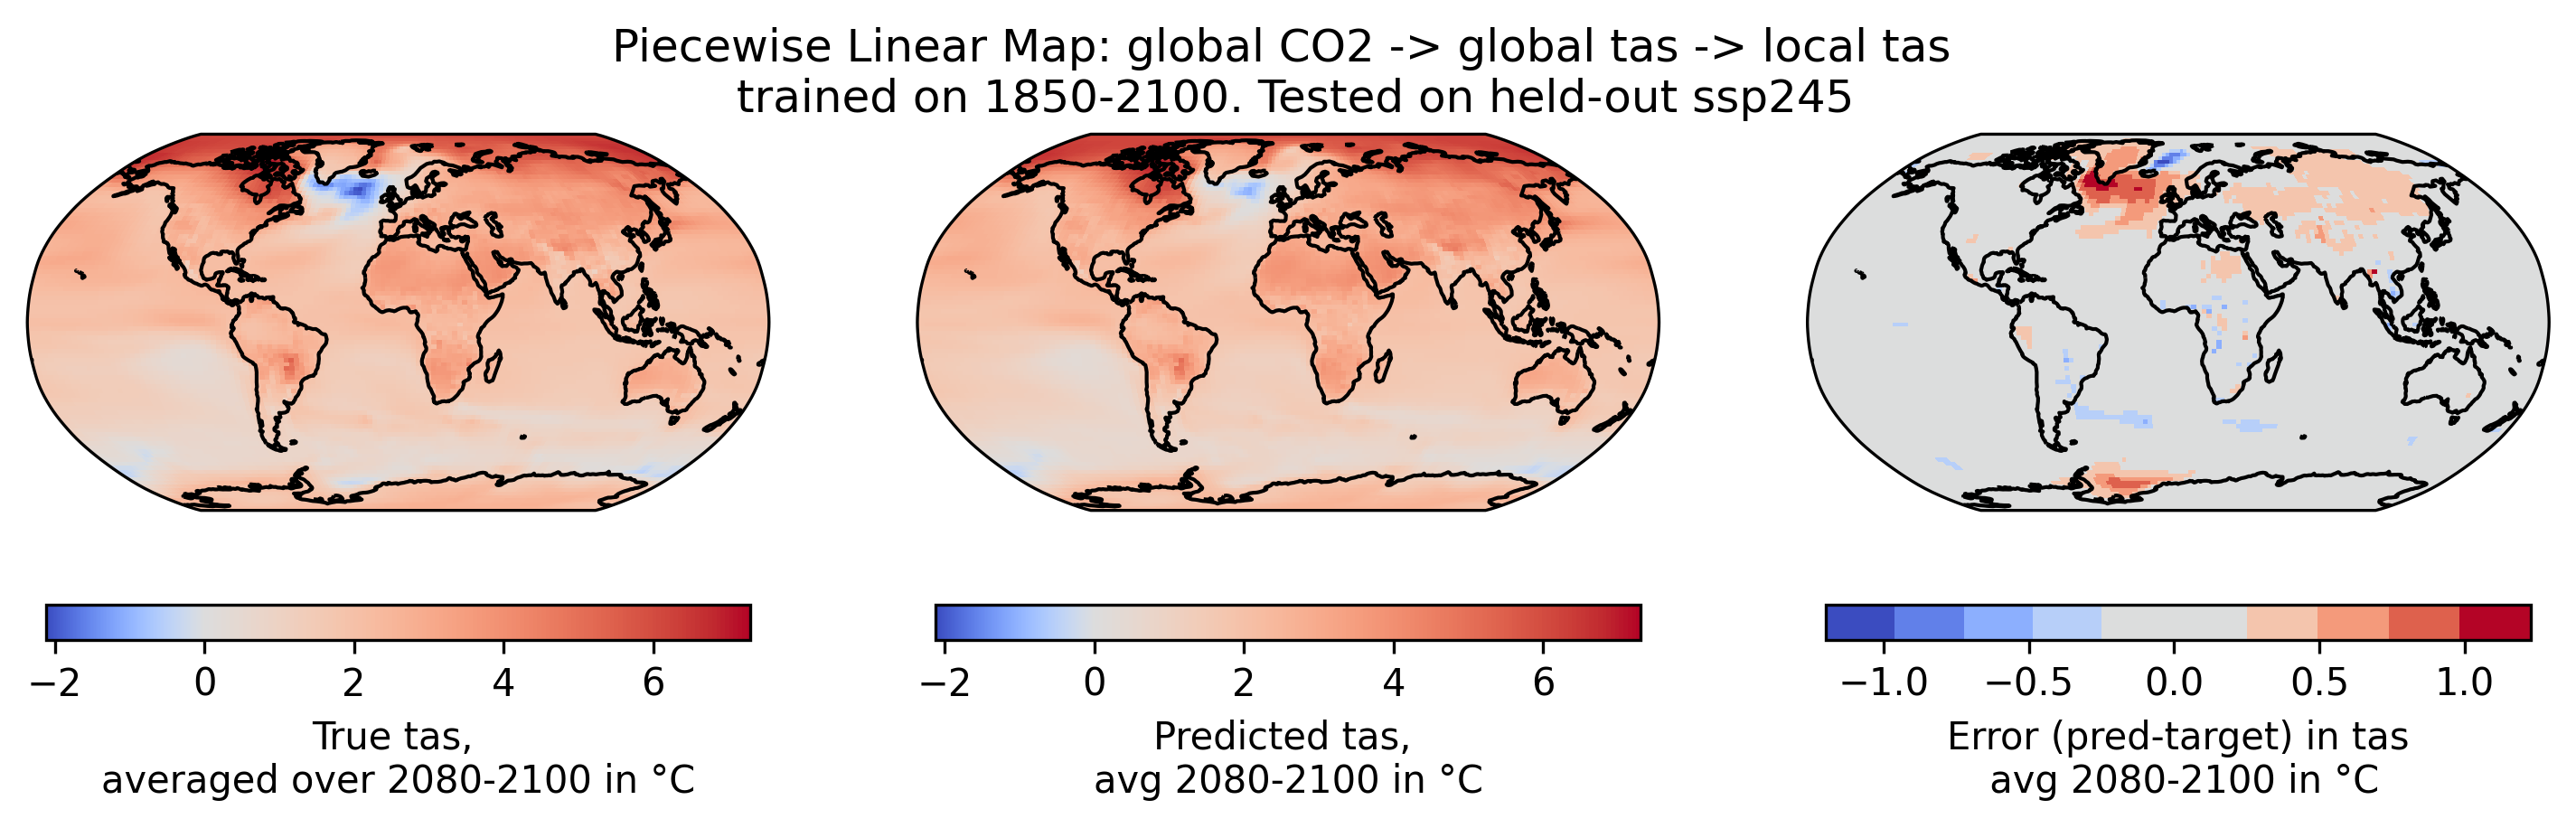

In [58]:
# Plot error map
from emcli.utils.plotting import plot_tas_annual_local_err_map

preds_pattern_scaling_xr = xr.DataArray(data=preds_pattern_scaling, 
    coords=Y_test[0][data_var].coords, name=data_var) # convert predictions into axarray
preds_pattern_scaling_ds = [xr.merge([preds_pattern_scaling_xr])]
axs = plot_tas_annual_local_err_map(Y_test[0][data_var], preds_pattern_scaling_ds[0][data_var], data_var=data_var, unit=data_var_labels[data_var]['unit'])
axs[1].set_title(f'Piecewise Linear Map: global CO2 -> global tas -> local {data_var} \n trained on 1850-2100. Tested on held-out {scenarios_test[0]}')
plt.show()

In [56]:
# Test calculation of NRMSE
from emcli.utils.metrics import calculate_nrmse

Y_nrmse = calculate_nrmse(Y_true=Y_test[0][data_var], Y_pred=preds_pattern_scaling_ds[0][data_var])
print(Y_nrmse)

2.2392805609573987


In [38]:
import pandas as pd
from xskillscore import rmse

def compute_metrics(variables, model_labels,models):
    Y = xr.open_dataset(data_path + 'outputs_ssp245.nc')
    Y = Y.rename({'lon':'longitude', 'lat': 'latitude'})
    # Convert the precip values to mm/day
    Y["pr"] *= 86400
    Y["pr90"] *= 86400


    weights = np.cos(np.deg2rad(Y['tas'].latitude)).expand_dims(longitude=144).assign_coords(lon=Y.longitude)

    def global_mean(ds):
        weights = np.cos(np.deg2rad(ds.latitude))
        return ds.weighted(weights).mean(['latitude', 'longitude'])

    # Spatial NRMSE
    NRMSE = pd.DataFrame({
        label: {variable: rmse(Y.mean('member')[variable].sel(time=slice(2080, None)).mean('time'), 
                                model[variable].sel(time=slice(2080, None)).mean('time'), weights=weights).data/ np.abs(global_mean(Y.mean('member')[variable].sel(time=slice(2080, None)).mean('time')).data) for variable in variables} 
        for label, model in zip(model_labels, models)
    })
    NRMSE.T.round(3).style.highlight_min(subset=slice("Random Forest", None), axis = 0, props='font-weight: bold').format("{:.4f}")
    print(f'spatial NRMSE, {NRMSE.keys()[0]} {NRMSE.index[0]}: {NRMSE[NRMSE.keys()[0]][NRMSE.index[0]]}')

    # Global NRMSE
    R2E = pd.DataFrame({
        label: {variable: rmse( global_mean(Y.mean('member')[variable].sel(time=slice(2080, None))), 
                                    global_mean(model[variable].sel(time=slice(2080, None)))).data/ np.abs(global_mean(Y.mean('member')[variable].sel(time=slice(2080, None)).mean('time')).data) for variable in variables} 
    #                                 global_mean(model[variable].sel(time=slice(2080, None)))).data for variable in variables} 
                            for label, model in zip(model_labels[:], models[:])
    })
    R2E.T.round(3).style.highlight_min(subset=slice("Random Forest", None), axis = 0, props='font-weight: bold').format("{:.4f}")
    print(f'global NRMSE, {R2E.keys()[0]} {R2E.index[0]}: {R2E[R2E.keys()[0]][R2E.index[0]]}')

    # Total NRMSE
    total_nrmse = (NRMSE+5*R2E)
    total_nrmse.T.round(3).style.highlight_min(subset=slice("Random Forest", None), axis = 0, props='font-weight: bold').format("{:.4f}")
    print(f'total NRMSE, {total_nrmse.keys()[0]} {total_nrmse.index[0]}: {total_nrmse[total_nrmse.keys()[0]][total_nrmse.index[0]]}')

    combined_df = pd.concat([NRMSE, R2E, NRMSE+5*R2E], keys=['Spatial', 'Global', 'Total'])[model_labels[:]].T.swaplevel(axis=1)[variables]
    combined_df.style.highlight_min(subset=slice(None, "Random Forest"), axis = 0, props='font-weight: bold').format("{:.3f}")

    return combined_df

variables = [data_var]
model_labels = ['Linear Pattern Scaling']
models = [preds_pattern_scaling_ds[0]]

compute_metrics(variables, model_labels,models)

    

spatial NRMSE, Linear Pattern Scaling diurnal_temperature_range: 7.958894903636085
global NRMSE, Linear Pattern Scaling diurnal_temperature_range: 2.0215814655549353
total NRMSE, Linear Pattern Scaling diurnal_temperature_range: 18.06680223141076


diurnal_temperature_range                     
                                         Spatial    Global      Total
Linear Pattern Scaling                  7.958895  2.021581  18.066802